
<h1> DS200A Computer Vision Assignment</h1>

<h2>  Part Three: Classifier training and performance assessment. </h2>	

In [1]:
from datainput import *
from preprocess import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, KFold, cross_val_score
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC


In [3]:
# try not to printout train_data['Pictures'] directly, takes a while
train_path = './20_categories_training/'
train_data = read_train_data(train_path)


## Helper Functions
Functions for train test split and cross validation, as well as functions to calculate accuracies

In [26]:
def train_test_split(df):
    """Split data into training and testing(validation)"""
    n, d = df.shape
    shuffled = np.arange(n)
    np.random.shuffle(shuffled)
    train_n = int(n*0.8)
    test_n = n-train_n
    train_idx = shuffled[:train_n]
    test_idx = shuffled[train_n:]
    return df.iloc[train_idx,:d-1], df.iloc[train_idx,d-1], df.iloc[test_idx,:d-1], df.iloc[test_idx,d-1]

def eval_socre(model, X, y):
    # used for cross validation
    return np.sum(model.predict(X) == y)/len(y)


def custom_cross_validate(df, model, fold = 5, func = eval_socre):
    """find cross validated accuracy scores"""
    # cross validation automatically apply standardscalar
    scalar = StandardScaler()
    pipeline = Pipeline([('transformer', scalar), ('estimator', model)])
    X, y  = df.iloc[:,:-1], df.iloc[:,-1]
    scores = cross_val_score(pipeline, X, y=y, scoring = func, cv = fold)
    return scores

def accuracy(pred, actual):
    return np.sum(pred==actual)/len(pred)


def create_plotting_df(scores, values):
    df = pd.DataFrame()
    for value, score_array in zip(values,scores):
        df = pd.concat([df,pd.DataFrame({'Values':np.ones(len(score_array))*value, 'Scores':score_array})])
    return df

## Convert Original Image DataFrame to Trainable DataFrame

In [4]:
# convert to trainable dataframe
df_X = feature_frame(train_data)

Trim all images..
Processing.. image size
Processing.. aspect ratio
Processing.. red-channel average
Processing.. green-channel average
Processing.. blue-channel average
Processing.. red-channel variance
Processing.. green-channel variance
Processing.. blue-channel variance
Processing.. laplacian average
Processing.. laplacian variance
Processing.. red-channel quantiles
Processing.. green-channel quantiles
Processing.. blue-channel quantiles
Processing.. laplacian quantiles


In [5]:
# split train_data into training and testing
X_train, y_train, X_test, y_test = train_test_split(df_X)

<h3>  Train models using all of the following methods below. Be sure to drop the actual image column, and the encoding</h3>	Take note of the differences in accuracy, and methods.


In [6]:
# standardize train test dataset
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Logistic Regression

In [9]:
# logistic with one over rest scheme
penalties = 10.0**np.arange(-3,5)
scores = []
for c in penalties:
    logistic_model = LogisticRegression(C=c, max_iter=100, solver='liblinear', multi_class='ovr', penalty='l2')
    scores.append(custom_cross_validate(df_X, logistic_model))

temp_ovr = create_plotting_df(scores, penalties)
print('Accuracy:', max([np.mean(x) for x in scores]))

Accuracy: 0.38757232940008646


In [133]:
# multinomial logistic regression
penalties = 10.0**np.arange(-3,5)
scores = []
for c in penalties:
    logistic_model = LogisticRegression(C=c, max_iter=200, solver='newton-cg', multi_class='multinomial')
    scores.append(custom_cross_validate(df_X, logistic_model))

temp_multi = create_plotting_df(scores, penalties)
print('Accuracy:', max([np.mean(x) for x in scores]))

/Users/joeylou/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/joeylou/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/joeylou/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/joeylou/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


Accuracy: 0.39939755927361875


/Users/joeylou/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


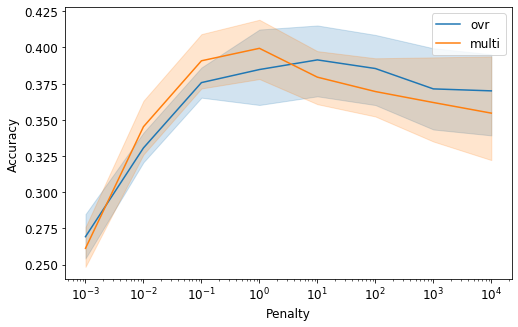

In [150]:
# plot validation set accuracies
plt.rcParams['font.size'] = 12
plt.figure(figsize=(8,5))
sns.lineplot(x = 'Values', y = 'Scores', markers=True, dashes=False, 
             data = temp_ovr, label = "ovr")
sns.lineplot(x = 'Values', y = 'Scores', data = temp_multi, label = "multi")
plt.legend()
plt.xscale('log'), plt.xlabel('Penalty'), plt.ylabel('Accuracy')
plt.savefig('images/logistic')
plt.show()

In [7]:
best_log = LogisticRegression(C=1, max_iter=100, solver='newton-cg', multi_class='multinomial')
best_log.fit(X_train,y_train)
print('Log Reg Accuracy:',accuracy(best_log.predict(X_test), y_test))

Log Reg Accuracy: 0.45514950166112955


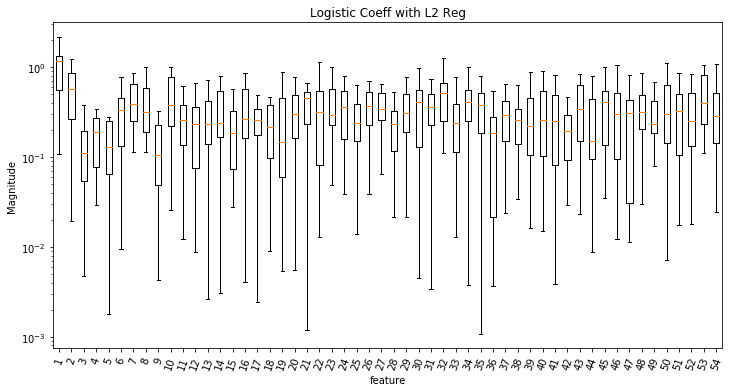

In [8]:
# visualize coefficients from best model
coeffs = np.abs(best_log.coef_)
k, d = coeffs.shape
plt.figure(figsize=(12,6))
plt.boxplot([coeffs[:,i] for i in range(d)], showfliers=False)
plt.yscale('log'), plt.xlabel('feature'), plt.ylabel('Magnitude'), plt.title('Logistic Coeff with L2 Reg')
plt.autoscale(), plt.xticks(rotation=70)
plt.savefig('images/logcoeffs')
plt.show()

## K-nearest Neighbors

In [140]:
neighbors = np.arange(5,50)
scores_d = []
scores_u = []
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors= i, weights='distance', leaf_size=30)
    scores_d.append(custom_cross_validate(df_X, knn))
    knn = KNeighborsClassifier(n_neighbors= i, weights='uniform', leaf_size=30)
    scores_u.append(custom_cross_validate(df_X, knn))
    
temp_d = create_plotting_df(scores_d, neighbors)
temp_u= create_plotting_df(scores_u, neighbors)


print('Accuracy:', max([np.mean(x) for x in scores_d]))
print('Accuracy:', max([np.mean(x) for x in scores_u]))

Accuracy: 0.33702432549374056
Accuracy: 0.3238031042408715


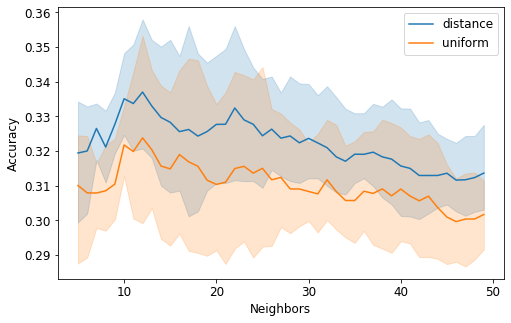

In [139]:
plt.figure(figsize=(8,5))
sns.lineplot(x = 'Values', y = 'Scores', data = temp_d, label = "distance")
sns.lineplot(x = 'Values', y = 'Scores', data = temp_u, label = "uniform")

plt.xlabel('Neighbors'), plt.ylabel('Accuracy')
plt.legend()
plt.savefig('images/knn')
plt.show()

## Classification Tree

In [39]:
depths = np.arange(5,20)
scores_t = []
scores_f = []
for depth in depths:
    print(depth,end='..')
    tree_model = DecisionTreeClassifier(max_depth=depth)
    scores_t.append(custom_cross_validate(df_X, tree_model))
    forest_model = RandomForestClassifier(max_depth=depth, n_estimators=100)
    scores_f.append(custom_cross_validate(df_X, forest_model))
    
temp_t = create_plotting_df(scores_t, depths)
temp_f= create_plotting_df(scores_f, depths)


print('Tree Max CV Accuracy:', max([np.mean(x) for x in scores_t]))
print('Forest Max CV Accuracy:', max([np.mean(x) for x in scores_f]))

5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..Tree Max CV Accuracy: 0.31211266658130976
Forest Max CV Accuracy: 0.39487232192674576


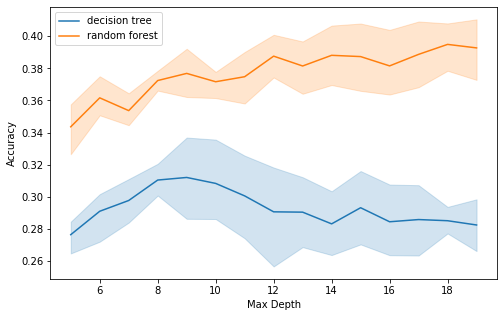

In [40]:
plt.figure(figsize=(8,5))
sns.lineplot(x = 'Values', y = 'Scores', data = temp_t, label = "decision tree")
sns.lineplot(x = 'Values', y = 'Scores', data = temp_f, label = "random forest")

plt.xlabel('Max Depth'), plt.ylabel('Accuracy')
plt.legend()
plt.savefig('images/trees')
plt.show()

In [41]:
best_depth = depths[np.argmax([np.mean(x) for x in scores_f])]
best_forest = RandomForestClassifier(max_depth=best_depth, n_estimators=100)
best_forest.fit(X_train, y_train)
print('Forest Accuracy:',accuracy(best_forest.predict(X_test), y_test))

Forest Accuracy: 0.38870431893687707


## Support Vector Machine

In [141]:
penalties = 10.0**np.arange(-3,5)
scores = []
for c in penalties:
    svm_model = LinearSVC(C=c, dual=False, max_iter=2000)
    scores.append(custom_cross_validate(df_X, svm_model))

temp_svm = create_plotting_df(scores, penalties)
print('Accuracy:', max([np.mean(x) for x in scores]))

/Users/joeylou/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joeylou/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joeylou/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joeylou/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/joeylou/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/svm/base.py:929: Conver

Accuracy: 0.3982249523938158


/Users/joeylou/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


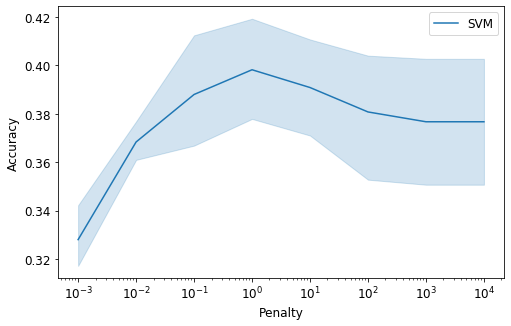

In [142]:
plt.figure(figsize=(8,5))
sns.lineplot(x = 'Values', y = 'Scores', data = temp_svm, label = "SVM")
plt.xscale('log'), plt.xlabel('Penalty'), plt.ylabel('Accuracy')
plt.savefig('images/svm')
plt.show()

/Users/joeylou/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


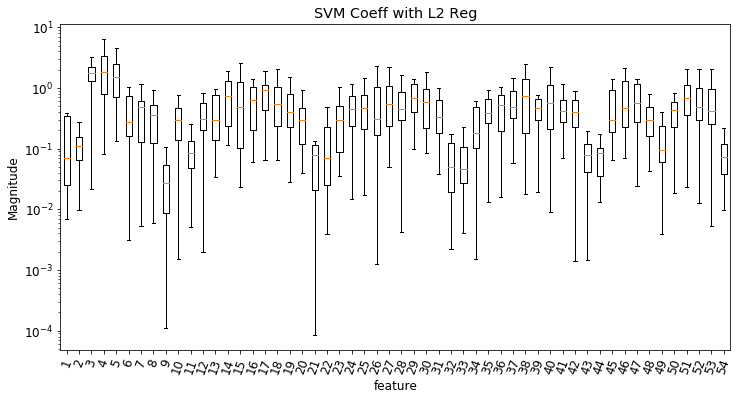

In [143]:
# visualize coefficients
best_model = LinearSVC(C=c, dual=False, max_iter=2000)
best_model.fit(X_train,y_train)
coeffs = np.abs(best_model.coef_)
k, d = coeffs.shape
plt.figure(figsize=(12,6))
plt.boxplot([coeffs[:,i] for i in range(d)], showfliers=False)
plt.yscale('log'), plt.xlabel('feature'), plt.ylabel('Magnitude'), plt.title('SVM Coeff with L2 Reg')
plt.autoscale(), plt.xticks(rotation=70)
plt.savefig('images/svmcoeffs')
plt.show()

## Predict Test Set

In [55]:
val_path = './20_Validation/'
test_data = read_test_data(val_path)

In [56]:
# convert to trainable dataframe
# train_df = feature_frame(train_data)
test_df = feature_frame(test_data)

Trim all images..
Processing.. image size
Processing.. aspect ratio
Processing.. red-channel average
Processing.. green-channel average
Processing.. blue-channel average
Processing.. red-channel variance
Processing.. green-channel variance
Processing.. blue-channel variance
Processing.. laplacian average
Processing.. laplacian variance
Processing.. red-channel quantiles
Processing.. green-channel quantiles
Processing.. blue-channel quantiles
Processing.. laplacian quantiles


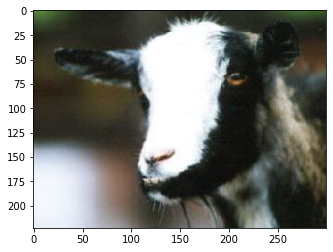

In [58]:
plt.imshow(test_data.iloc[100,0])

In [8]:
train_df.shape, test_df.shape

((1501, 55), (716, 54))

In [59]:
# use full training set
ftrain_X, ftrain_y = train_df.iloc[:,:-1], train_df.iloc[:,-1]
scaler = StandardScaler()
scaler.fit(ftrain_X)
ftrain_X = scaler.transform(ftrain_X)
ftest_X = scaler.transform(test_df)

In [60]:
FE = feature_extract()
best_log = LogisticRegression(C=1, max_iter=1000, solver='newton-cg', multi_class='multinomial')
best_log.fit(ftrain_X, ftrain_y)
pred_y = best_log.predict(ftest_X)
# save to csv
final_prediction = pd.DataFrame([FE.labels[x] for x in pred_y])
final_prediction.to_csv('predicted_result.csv', header=False, index=False)

In [18]:
def read_train_data2(file_path):
    # return training dataset with correct encoding labeled
    filemap = {0: "Airplanes", 1: "Bear", 2: "Blimp", 3: "Comet", 4: "Crab",
               5: "Dog", 6: "Dolphin", 7: "Giraffe", 8: "Goat", 9: "Gorilla",
               10: "Kangaroo", 11: "Killer-Whale", 12: "Leopards", 13: "Llama",
               14: "Penguin", 15: "Porcupine", 16: "Teddy-Bear", 17: "Triceratops",
               18: "Unicorn", 19: "Zebra"}
    image_array = []
    image_name = []
    encoding_array = []
    for encoding in range(20):
        current_folder = os.path.join(file_path, filemap[encoding])
        for file in os.listdir(current_folder):
            if file.startswith('.'):
                continue
            image_array.append(io.imread(os.path.join(current_folder, file)))
            image_name.append(re.findall(r'[0-9]+', file)[0])
            encoding_array.append(encoding)
    res = pd.DataFrame()
    res['Pictures'] = image_array
    res['Encoding'] = encoding_array
    res['Order'] = image_name
    return res

In [94]:
def read_test_data2(file_path):
    # read test dataset with correct orderings based on file name
    image_array = []
    image_name = []
    for file in os.listdir(file_path):
        if file.startswith('.'):
            continue
        image_name.append(re.findall(r'[0-9]+', file)[0])
        image_array.append(io.imread(os.path.join(file_path, file)))
    res = pd.DataFrame()
    res['Pictures'] = image_array
    res['Order'] = image_name
    return res

In [19]:
cheat_set = read_train_data2('./20_categories_valid_classified/20_categories_training/')

In [44]:
cheat_set = cheat_set.iloc[np.argsort(cheat_set.iloc[:,2].apply(int))].reset_index()

In [45]:
cheat_frame = feature_frame(cheat_set)

Trim all images..
Processing.. image size
Processing.. aspect ratio
Processing.. red-channel average
Processing.. green-channel average
Processing.. blue-channel average
Processing.. red-channel variance
Processing.. green-channel variance
Processing.. blue-channel variance
Processing.. laplacian average
Processing.. laplacian variance
Processing.. red-channel quantiles
Processing.. green-channel quantiles
Processing.. blue-channel quantiles
Processing.. laplacian quantiles


In [43]:
cheat_set.reset_index(inplace=True)

,index,Pictures,Encoding,Order
0,545,"[[[80, 79, 74], [56, 55, 50], [54, 53, 48], [4...",14,1
1,514,"[[[10, 15, 19], [10, 15, 19], [11, 16, 19], [1...",14,2
2,523,"[[[232, 231, 247], [250, 249, 255], [235, 234,...",14,3
3,527,"[[[97, 75, 77], [98, 76, 78], [99, 77, 79], [1...",14,4
4,532,"[[[19, 46, 55], [19, 46, 53], [20, 47, 54], [2...",14,5
...,...,...,...,...
683,423,"[[[64, 70, 84], [64, 70, 82], [65, 72, 82], [6...",11,712
684,413,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",11,713
685,427,"[[[127, 178, 241], [124, 176, 236], [124, 176,...",11,714
686,424,"[[[71, 97, 122], [70, 91, 118], [66, 86, 113],...",11,715


In [47]:
cheat_X, cheat_y = scaler.transform(cheat_frame.iloc[:,:-1]), cheat_frame.iloc[:,-1]

In [48]:
print('Logistic Accuracy:', accuracy(best_log.predict(cheat_X), cheat_y))

Logistic Accuracy: 0.3633720930232558


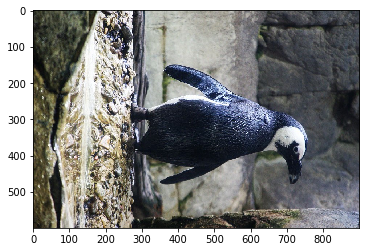

In [50]:
plt.imshow(cheat_set.iloc[0,1])

In [62]:
dum = best_log.predict(cheat_X)

In [71]:
x = np.zeros(pred_y.shape)
x[cheat_set.Order.apply(int)-1] = dum

In [74]:
sum(x == pred_y)

688

(716,)

In [63]:
pred_y, dum

(array([14, 15,  5,  3,  3, 14, 14,  7, 14,  1,  3,  5, 14, 12,  9, 18, 14,
         6,  9,  5, 14, 14, 19,  9,  2, 11, 14,  1, 14, 13, 16, 10, 14, 16,
         5,  9,  4,  9,  9, 11, 18,  4,  5,  0,  5,  5,  1, 19,  7, 19, 19,
        19, 15, 19,  7, 19,  4,  9, 19,  4, 13, 19,  2, 19, 15, 19,  9, 15,
        15, 19, 19, 19,  9, 19,  4, 15, 19, 19,  8, 10,  7, 14, 16,  0, 17,
        13,  6, 17, 13, 14, 13, 13,  5,  5,  1,  1, 15, 10,  9, 13,  8, 19,
        14,  9,  9, 16, 18, 18, 12,  9,  3, 15,  7, 10, 16, 17, 17,  9,  4,
        17, 17,  9, 16,  5, 17,  9,  9, 19, 13, 17, 16, 16, 17, 17, 14,  9,
         9, 17,  2,  8, 13, 18, 19, 17, 15, 10,  7, 13,  5, 13,  4,  9,  9,
        10,  4, 13,  9, 16, 15,  4, 16, 13, 13,  9,  0,  9,  9,  5, 16,  5,
        16,  5,  4, 13, 16, 18,  5, 16,  1,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3, 12, 12, 12, 12, 12,  7,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 